In [1]:
import os
import functools as ftools
import itertools as itools
import pandas as pd
import polars as pl
import numpy as np

import sgml, dproc, sgnn, sgutil
import tensorflow as tf
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import dill

import seaborn as sns
import matplotlib.pyplot as plt

2024-12-01 01:41:25.119097: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 01:41:25.337680: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 01:41:26.036877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score

In [12]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

with open(os.path.join('data', 'var_w.dill'), 'rb') as f:
    df_var = dill.load(f)
df_train = pd.read_feather(os.path.join('data', 'train_w.feather'))
sc = sgutil.SGCache('img', 'result')
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
ss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
target = 'Depression'

In [13]:
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction, stratify=x[target])

def print_metrics(title, m):
    print("Accuracy, {}: {:.5f}±{:.5f}".format(
        title, np.mean(m), np.std(m)
    ))

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index=df.index),
    'score_func': lambda df, prds: accuracy_score(df[target].sort_index(), prds.sort_index() > 0.5),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'y': target,
}

lgb_adapter = sgml.LGBMAdapter(model=lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(model=xgb.XGBClassifier)
cb_adapter = sgml.CBAdapter(model=cb.CatBoostClassifier)
lr_adapter = sgml.SklearnAdapter(model=LogisticRegression)

def show_result_lgb(result):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sns.barplot(
        pd.concat([i['feature_importance'] for i in result['model_result']], axis=1).mean(axis=1)\
        .sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
        x = 'Importance', y = 'feature', ax=axes[0]
    )
    if result['model_result'][0]['valid_result'] is not None:
        valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
        sns.lineplot(valid_result, ax=axes[1])
        if 'valid_1' in valid_result:
            axes[1].axvline(valid_result['valid_1'].idxmin())
    plt.tight_layout()
    plt.show()

In [14]:
df_var.sort_values('n_unique', ascending=False)

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
id,0.0,234499.0,0.0,234500.0,117250.0,True,True,False,False,Int32,Int32,None,org,None
Prof_Degree,None,None,0.0,140700.0,522.0,None,None,None,None,None,Categorical,Profession_R2과 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7f8f208c3100>
Name,None,None,0.0,234500.0,398.0,True,True,True,True,Categorical,Categorical,None,org,None
CGPA_FN,0.0,10.0,0.0,140700.0,333.0,True,True,True,True,None,Float64,{}의 결측을 처리한 변수입니다.,fillna,<function get_fillna_proc.<locals>.num_proc at...
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,None,org,None
Name_R,None,None,0.0,140700.0,218.0,None,None,None,None,None,Categorical,Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.,cat_proc,<function get_name_proc.<locals>.<lambda> at 0...
Degree,None,None,4.0,234496.0,102.0,True,True,True,True,Categorical,Categorical,None,org,None
City,None,None,0.0,234500.0,83.0,True,True,True,True,Categorical,Categorical,None,org,None
Profession,None,None,61262.0,173238.0,65.0,True,True,True,True,Categorical,Categorical,None,org,None
WS_Degree,None,None,0.0,140700.0,48.0,None,None,None,None,None,Categorical,Working Professional or Student와 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7f8f208c3560>


In [22]:
age_proc = lambda x: x['Age'].astype('int').clip(18, 60)
age_c_proc = lambda x: x['Age'].astype('int').clip(18, 60).where(~x['is_student'], x['Age'].clip(18, 34)).rename('Age_C')
cgpa_proc = lambda x: (x['CGPA_FN'].clip(0.0,10.0).round(1).replace({4.0: 5.5, 5.0: 5.5}) * 10).rename('CGPA_C').astype('int')
ml_proc_list = [
    (age_proc, 'Age를 정수로 만듭니다'),
    (age_c_proc, 'Age를 범주화하면서 학생의 나이를 18~34로 한정시킵니다.'),
    (cgpa_proc, 'CGPA를 1의 자리까지 반올림하고, *10을 하여 정수형으로 만듭니다'),
]
df_ml, df_ml_var = dproc.apply_pd(df_train, ml_proc_list, 'ml')
df_train = dproc.join_and_assign(df_train, df_ml)
df_var = pd.concat([df_var, df_ml_var]).groupby(level=0).last()

# LogisticRegression

In [23]:
cv_path = os.path.join('result', 'LR.cv')
if os.path.exists(cv_path):
    lr = sgml.CVModel.load('result', 'LR')
else:
    lr = sgml.CVModel('result', 'LR', skf, config, lr_adapter)

In [165]:
hparams = {
    'model_params': {'C': 1},
    'X_mm':  [
        'Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 'Study Hours'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'Study Hours', 'Family History of Mental Illness', 
              'Dietary Habits_R', 'Sleep Duration_R', 'Degree_R', 'City_R', 'Name_R', 'Profession_R2', 'Age', 'CGPA_C'],
    'ohe': {'drop': 'first', 'min_frequency': 50}
}

result = lr.cv(df_train, hparams)
np.mean(result['valid_scores'])

0.9398507462686567

# LGB1

In [70]:
cv_path = os.path.join('result', 'LGB1.cv')
if os.path.exists(cv_path):
    lgb1 = sgml.CVModel.load('result', 'LGB1')
else:
    lgb1 = sgml.CVModel('result', 'LGB1', skf, config, lgb_adapter)

In [168]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.02, 'num_leaves': 15, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'CGPA_FN', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Age'],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
}
#result = lgb1.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
#print(result['valid_scores'])

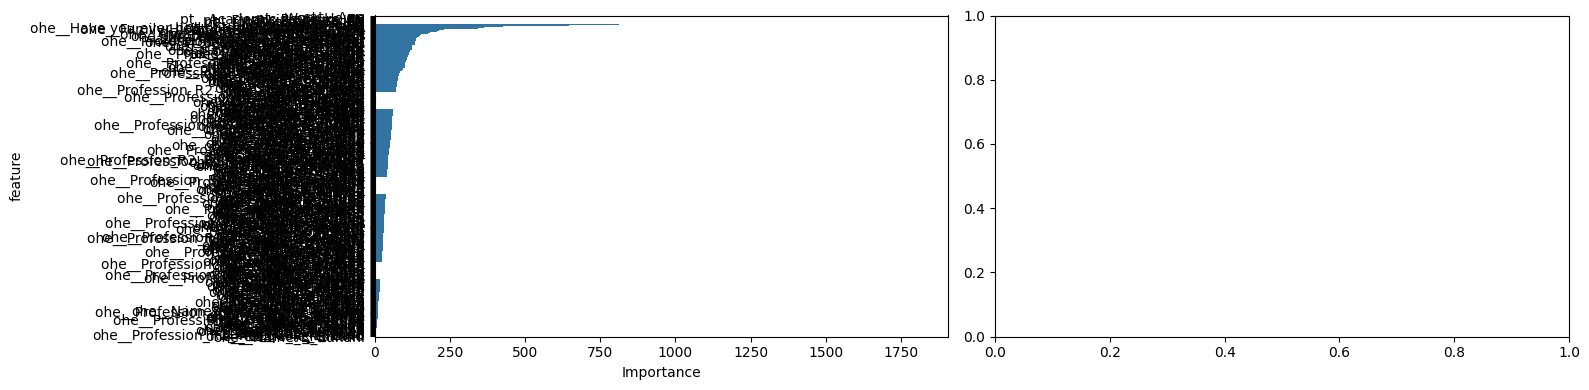

Accuracy, Valid.: 0.94061±0.00146


In [169]:
result = lgb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.02, 'num_leaves': 15, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Academic Pressure_FN, Financial Stress_FN, Work Pressure_FN, Study Satisfaction_FN, Job Satisfaction_FN, Work Hours, Study Hours, CGPA_FN, Dietary_level, Sleep_level]"
X_cat,[Age]
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age_2, Gender]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


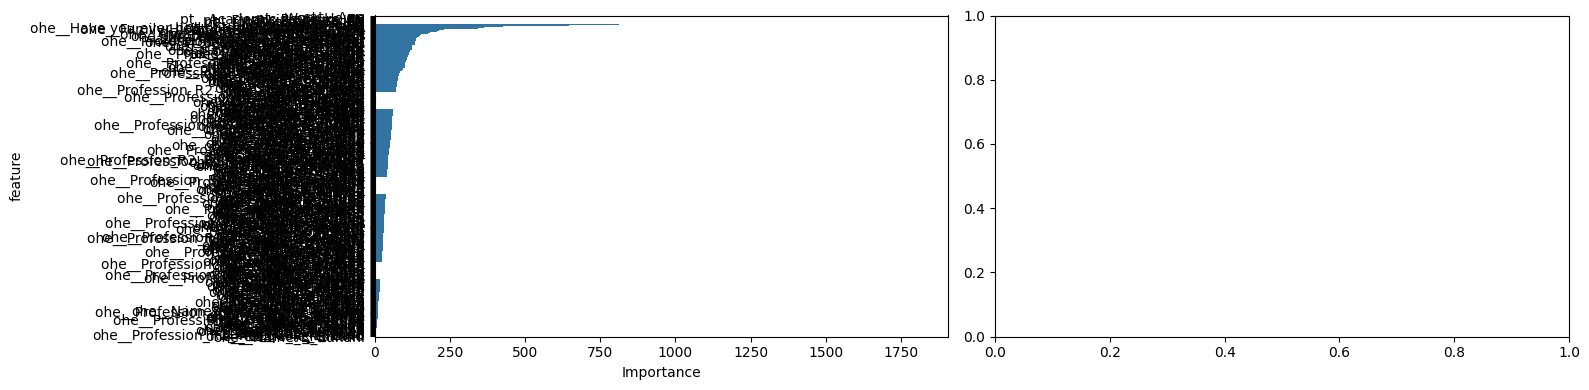

0.9406112295664535


In [170]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(lgb1.get_best_result())
print(lgb1.cv_best_['score'])

# XGB1

In [186]:
cv_path = os.path.join('result', 'XGB1.cv')
if os.path.exists(cv_path):
    xgb1 = sgml.CVModel.load('result', 'XGB1')
else:
    xgb1 = sgml.CVModel('result', 'XGB1', skf, config, xgb_adapter)

In [187]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.02, 'max_depth': 4, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 
              'Degree_R', 'City_R', 'Profession_R2', 'Age', 'Gender', 'CGPA_C'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    #'validation_fraction': 0.1
}
#xgb1.adhoc(df_train, ss, hparams, device='cuda')

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

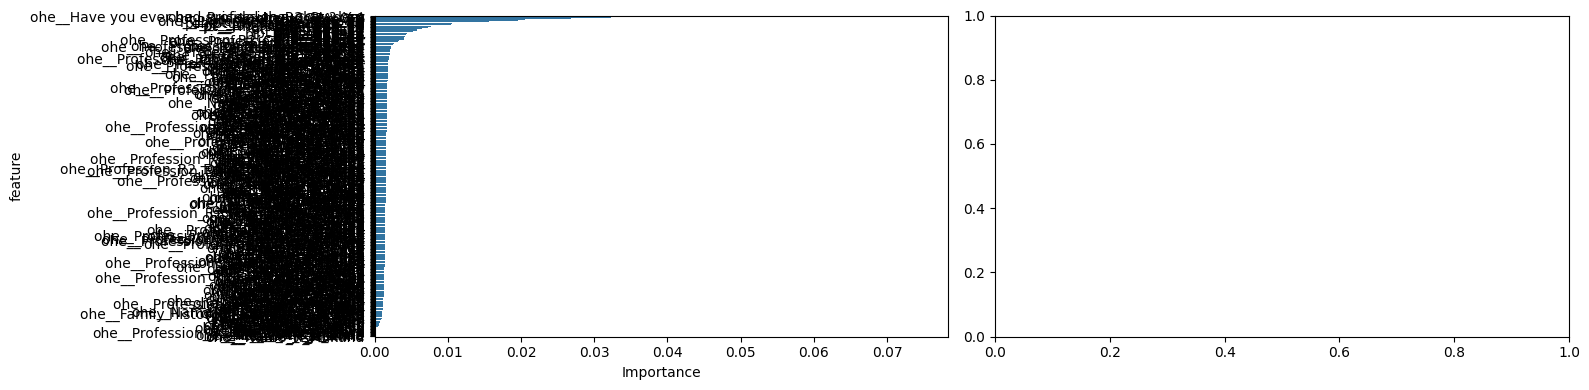

Accuracy, Valid.: 0.94064±0.00158


In [188]:
result = xgb1.cv(df_train, hparams, device='cuda')
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.02, 'max_depth': 4, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure_FN, Financial Stress_FN, Work Pressure_FN, Study Satisfaction_FN, Job Satisfaction_FN, Work Hours, Study Hours, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age, Gender, CGPA_C]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


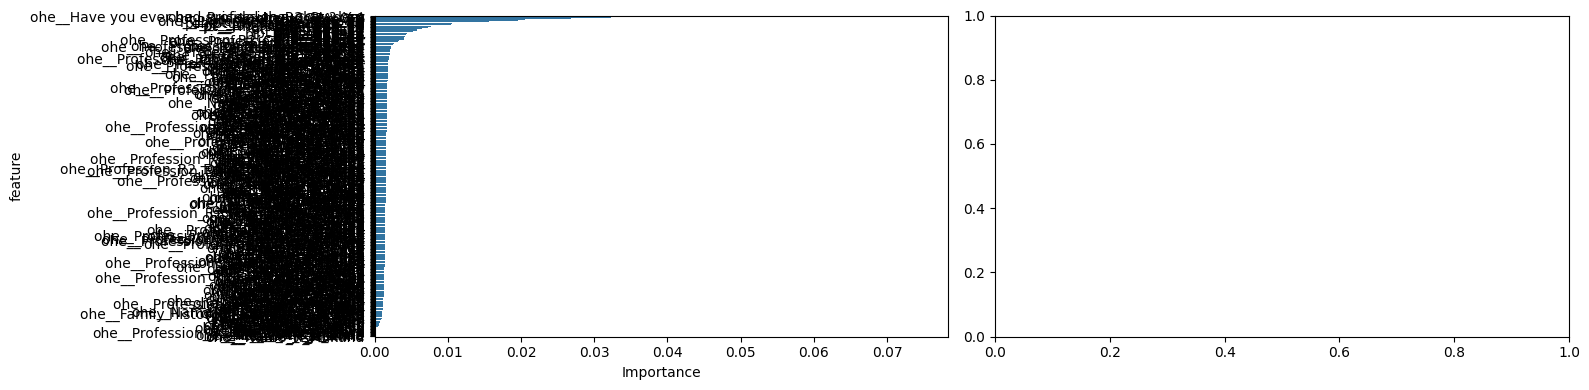

0.9406396588486141


In [189]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(xgb1.get_best_result())
print(xgb1.cv_best_['score'])

# XGB2

In [195]:
cv_path = os.path.join('result', 'XGB2.cv')
if os.path.exists(cv_path):
    xgb2 = sgml.CVModel.load('result', 'XGB2')
else:
    xgb2 = sgml.CVModel('result', 'XGB2', skf, config, xgb_adapter)

In [196]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.03, 'max_depth': 3, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work Hours', 
        'Study Hours', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 
              'Degree_R', 'City_R', 'Profession_R2', 'Age', 'Gender', 'CGPA_C'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    #'validation_fraction': 0.1
}
# xgb2.adhoc(df_train, ss, hparams, device='cuda')

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

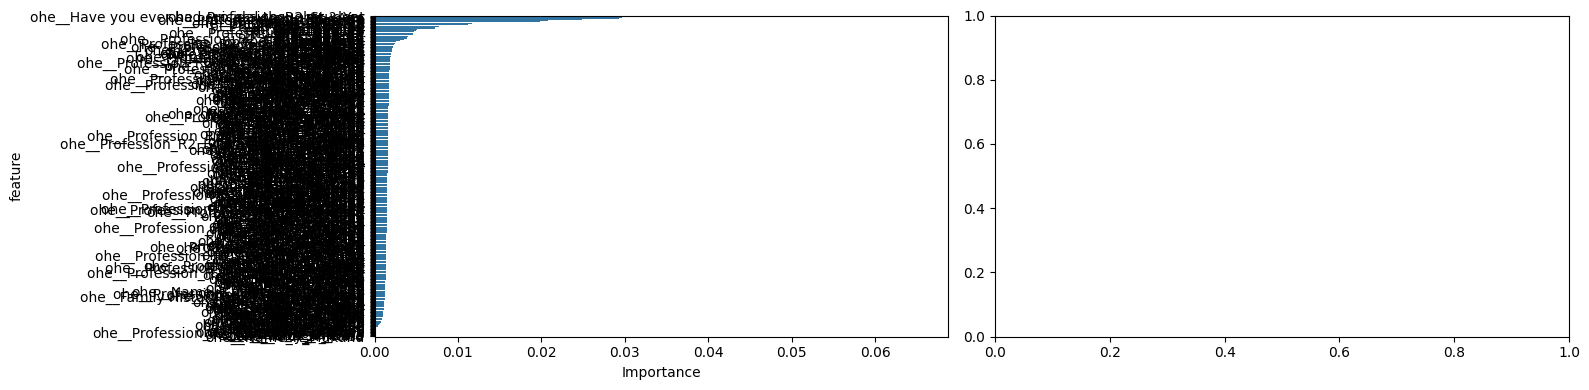

Accuracy, Valid.: 0.94045±0.00182


In [197]:
result = xgb2.cv(df_train, hparams, device='cuda')
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.03, 'max_depth': 3, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure, Financial Stress, Work Pressure, Study Satisfaction, Job Satisfaction, Work Hours, Study Hours, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age, Gender, CGPA_C]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


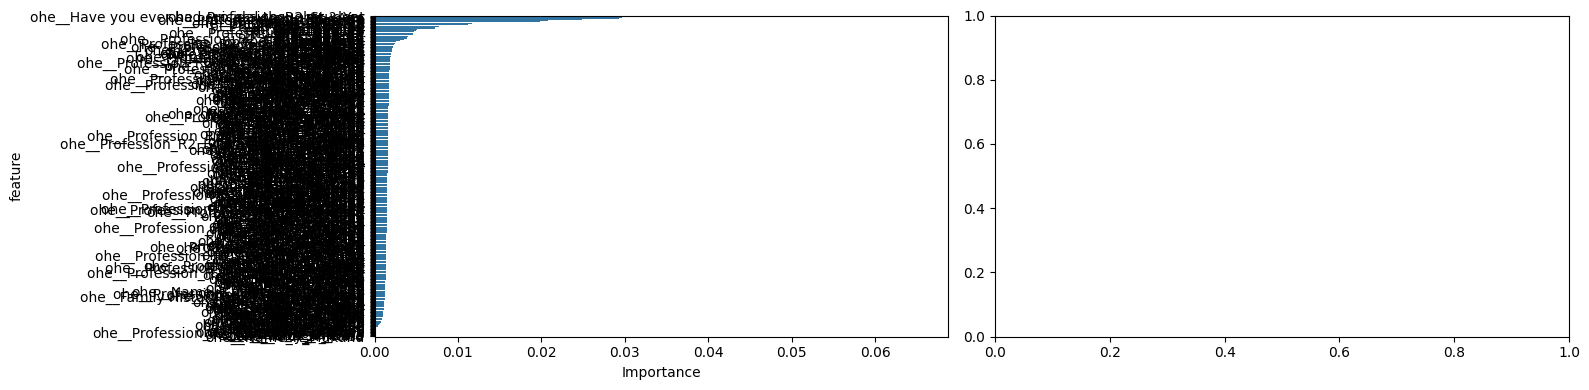

0.94045486851457


In [198]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb2.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(xgb2.get_best_result())
print(xgb2.cv_best_['score'])

# CB

In [82]:
cv_path = os.path.join('result', 'CB1.cv')
if os.path.exists(cv_path):
    cb1 = sgml.CVModel.load('result', 'CB1')
else:
    cb1 = sgml.CVModel('result', 'CB1', skf, config, cb_adapter)

In [83]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.03, 'max_depth': 5, 'rsm': 0.5},
    'X_num':  [
        'Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 
              'Degree_R', 'City_R', 'Profession_R2', 'Age', 'Gender', 'CGPA_C'],
    # 'validation_fraction': 0.1
}
# result = cb1.adhoc(df_train, ss, hparams)

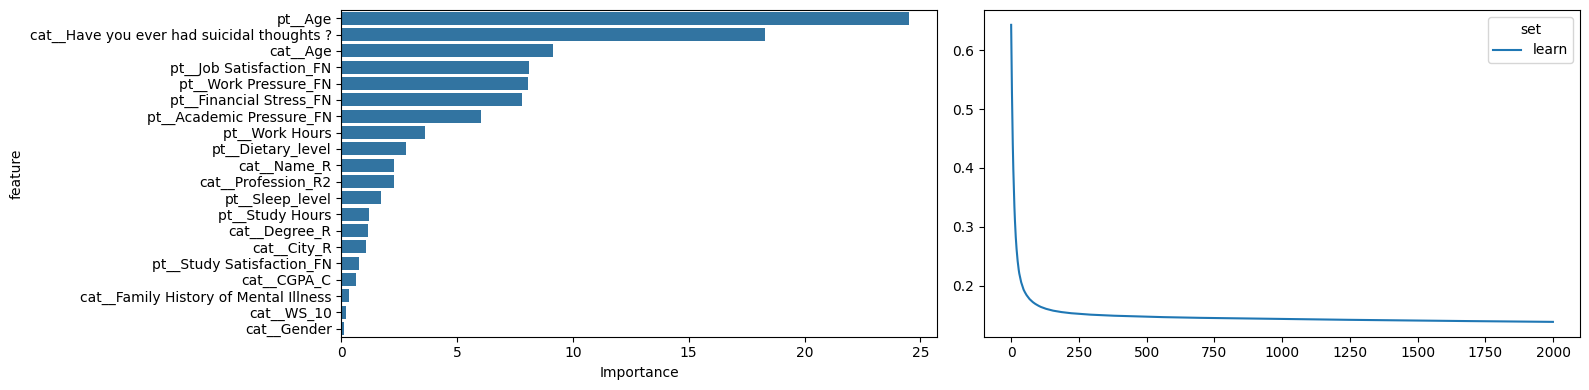

Accuracy, Valid.: 0.94093±0.00202


In [84]:
result = cb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.03, 'max_depth': 5, 'rsm': 0.5}"
X_num,"[Age, Academic Pressure_FN, Financial Stress_FN, Work Pressure_FN, Study Satisfaction_FN, Job Satisfaction_FN, Work Hours, Study Hours, Dietary_level, Sleep_level]"
X_cat,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age, Gender, CGPA_C]"


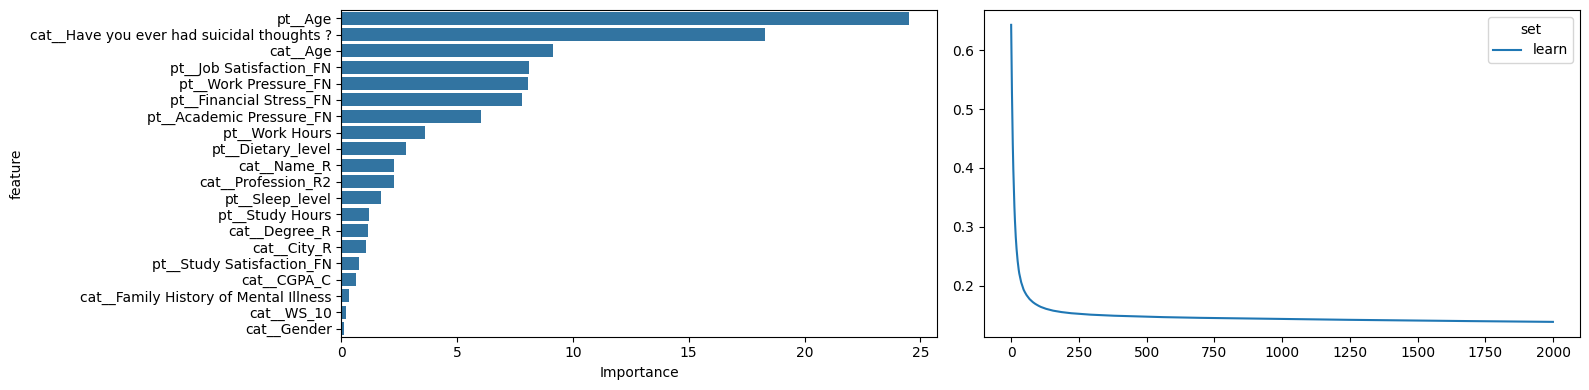

0.9409310589907605


In [85]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(cb1.get_best_result())
print(cb1.cv_best_['score'])

# NN

In [86]:
import importlib
import sgnn
importlib.reload(sgnn)

<module 'sgnn' from '/mnt/d/work/sunkusun9/kaggle/PGS4_ep11/sgnn.py'>

In [87]:
import sgnn
nn_adapter = sgnn.NNAdapter(model=sgnn.NNClassifier)

In [88]:
cv_path = os.path.join('result', 'NN1.cv')
if os.path.exists(cv_path):
    nn1 = sgml.CVModel.load('result', 'NN1')
else:
    nn1 = sgml.CVModel('result', 'NN1', skf, config, nn_adapter)

In [89]:
def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size

X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R']
X_nn_emb = [
    ('Name_R', 3), ('City_R', 2), ('Profession_R2', 2), ('Degree_R', 2)
]

nn_params = {
    'embedding':[(1, c, es, 0, 0) for _, c, es in [nn_cat_param(df_train, v, n) for v, n in X_nn_emb]], 
    'config':  [
        {'unit': 4, 'activation': 'relu', 'batch_norm': False},
#        {'unit': 4, 'activation': 'relu', 'batch_norm': False},
    ]
}

hparams = {
    'model_params': {
        'model_params': nn_params,
        'epochs': 30,
        'optimizer': ('Adam', {'learning_rate': 0.003}),
        'batch_size': 2048, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_cat': [i for i, _ in X_nn_emb],
    'X_std':  [
        'Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Age', 'CGPA_C'],
    'ohe': {'drop': 'first', 'min_frequency': 50, 'sparse_output': False},
    #'validation_fraction': 0.1
}

#nn1.adhoc(df_train, ss, hparams)

In [90]:
"""
class DepressionModel(tf.keras.Model):
    def __init__(self, emb_cols, cont_cols, f_size, left_layers, right_layers, top_layers):
        super().__init__()
        if emb_cols != None:
            self.emb_layers = {
                v.replace(' ', '_').replace('?', '_'): tf.keras.layers.Embedding(c, s, name=v.replace(' ', '_').replace('?', '_')) for v, c, s in emb_cols
            }
            self.emb_cc = tf.keras.layers.Concatenate(axis=-1)
            if left_layers != None:
                self.left_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in left_layers
                ])
                self.right_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in right_layers
                ])
                self.mul = tf.keras.layers.Multiply()
                self.left_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.left_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
                self.right_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.right_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
            else:
                self.left_model = None
        else:
            self.emb_layers = None
        self.top_cc = tf.keras.layers.Concatenate(axis=-1)
        self.top_model = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(**params) if 'rate' in params else tf.keras.layers.Dense(**params) for params in top_layers
        ])
        self.f_size = f_size
        self.cont_cols = cont_cols
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def __call__(self, X):
        if self.emb_layers != None:
            X_emb = self.emb_cc([tf.squeeze(v(X[k]), axis=-2) for k, v in self.emb_layers.items()])
            if self.left_model !=None:
                X_left = self.left_model(X_emb)
                X_right = self.right_model(X_emb)
                X_left_1 = self.left_slice_layer_1(X_left)
                X_left_2 = self.left_slice_layer_2(X_left)
                
                X_right_1 = self.right_slice_layer_1(X_right)
                X_right_2 = self.right_slice_layer_2(X_right)
                X_mul = self.mul([X_left_1, X_right_1])
                cc_list = [X_left_2, X_right_2, X_mul]
            else:
                cc_list = [X_emb]
        else:
            cc_list = list()
        if self.cont_cols != None:
            cc_list.append(X[self.cont_cols])
        if len(cc_list) == 1:
            return self.sigmoid(
                self.top_model(cc_list[0])
            )
        else:
            return self.sigmoid(
                self.top_model(self.top_cc(cc_list))
            )

def to_tf_dataset(X, Y=None, sample_weights=None, cont=[], cat=[]):
    d = {}
    c = 0
    for i in cat:
        d[i.replace(' ', '_').replace('?', '_')] = np.expand_dims(X[:, c].astype('int'), axis=-1)
        c += 1
        
    if len(cont) > 0:
        d['Continous'] =  X[:, c:]
    if Y is None:
        return tf.data.Dataset.from_tensor_slices(d)
    else:
        if type(Y) == pd.Series:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y.values))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y.values, sample_weights.values))
        else:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y, sample_weights))

def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size


X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R', 'Sleep Duration_R', 'Dietary Habits_R', 
         'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness']
X_num = ['CGPA_FZ', 'Work Hours', 'Study Hours', 'Work Pressure_FZ', 'Academic Pressure_FZ', 
         'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Age', 'Financial Stress_FM', 'Sleep_level', 'Dietary_level']
X_nn_emb = [
    ('Name_R', 2), ('City_R', 2), ('Profession_R2', 2), ('Degree_R', 2), ('Sleep Duration_R', 1), ('Dietary Habits_R', 1), ('Working Professional or Student', 1), 
    ('Have you ever had suicidal thoughts ?', 1), ('Gender', 1), ('Family History of Mental Illness', 1)
]

nn_adapter = sgnn.NNAdapter(
    model=sgnn.NNClassifier,
    to_tf_dataset = ftools.partial(
        to_tf_dataset, 
        cont=X_num,
        cat=X_cat
    )
)
"""
' '

' '

In [91]:
"""nn_params = {
    'emb_cols': [
        nn_cat_param(df_train, v, n) for v, n in X_nn_emb
    ], 
    'cont_cols':  'Continous',
    'f_size':  16, 
    'left_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'right_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'top_layers': [
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'rate': 0.25},
        {'units': 16, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'rate': 0.25},
        {'units': 1, 'kernel_initializer': 'glorot_uniform'}
    ]
}

hparams = {
    'model_params': {
        'model': DepressionModel, 
        'model_params': nn_params,
        'epochs': 30,
        'optimizer': ('Adam', {'learning_rate': 0.0005}),
        'batch_size': 512, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_std': X_num,
    'X_cat': X_cat,
    'ohe': {'drop': 'first'}
}
nn1.adhoc(df_train, ss, hparams)
"""
' '

' '

In [92]:
result = nn1.cv(df_train, hparams)
print_metrics('Valid.', result['valid_scores'])

Accuracy, Valid.: 0.93947±0.00151


In [93]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(nn1.cv_best_['hparams']).rename('value').to_frame())
print(nn1.cv_best_['score'])

,value
model_params,"{'model_params': {'embedding': [(1, 218, 3, 0, 0), (1, 31, 2, 0, 0), (1, 38, 2, 0, 0), (1, 28, 2, 0, 0)], 'config': [{'unit': 4, 'activation': 'relu', 'batch_norm': False}]}, 'epochs': 30, 'optimizer': ('Adam', {'learning_rate': 0.003}), 'batch_size': 2048, 'shuffle_size': 102400, 'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None}"
X_cat,"[Name_R, City_R, Profession_R2, Degree_R]"
X_std,"[Age, Academic Pressure_FN, Financial Stress_FN, Work Pressure_FN, Study Satisfaction_FN, Job Satisfaction_FN, Work Hours, Study Hours, CGPA_FN, Dietary_level, Sleep_level]"
X_ohe,"[Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Age]"
ohe,"{'drop': 'first', 'min_frequency': 50, 'sparse_output': False}"


0.9397014925373135


# LGB + LDA

In [94]:
cv_path = os.path.join('result', 'LGB_LDA.cv')
if os.path.exists(cv_path):
    lgb_lda = sgml.CVModel.load('result', 'LGB_LDA')
else:
    lgb_lda = sgml.CVModel('result', 'LGB_LDA', skf, config, lgb_adapter)

In [95]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 7,
        'learning_rate': 0.04,
        'random_state' : 123,
        'colsample_bytree' : 0.25,
        'subsample': 0.25
    }, 
    'X_num':  [
        'Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'CGPA_FN', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Gender'],
    'X_cat': ['Age'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    'lda': {
        'X_mm':  [
            'Academic Pressure_FN', 'Study Hours', 'CGPA_FN', 'Age', 'Study Satisfaction_FN'
        ],
    },
}
#result = lgb_lda.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
# print(result['valid_scores'])

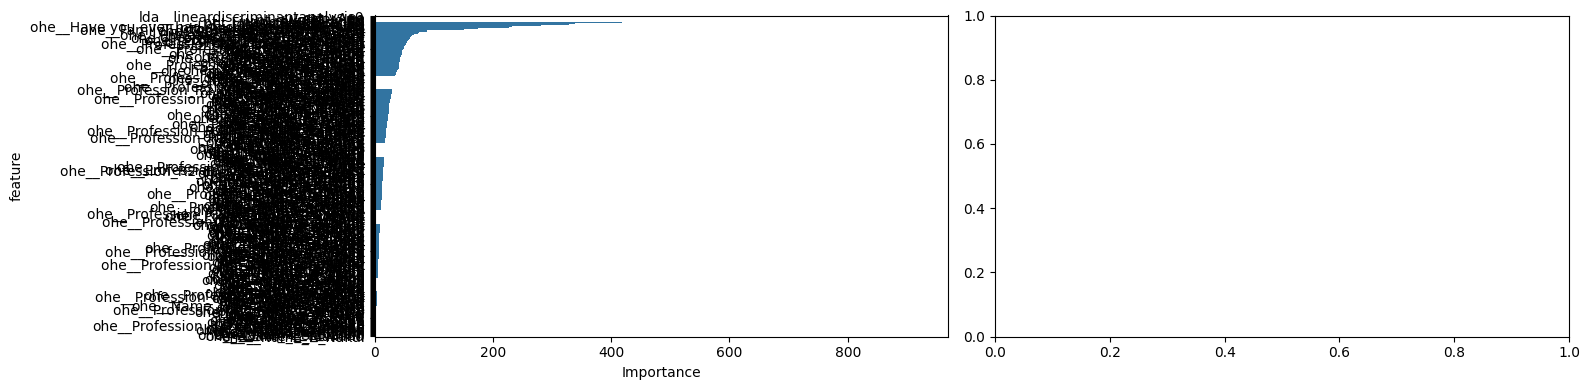

Accuracy, Valid.: 0.94056±0.00171


In [96]:
result = lgb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [97]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb_lda.cv_best_['hparams']).rename('value').to_frame())
print(lgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 7, 'learning_rate': 0.04, 'random_state': 123, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Age, Academic Pressure_FN, Financial Stress_FN, Work Pressure_FN, Study Satisfaction_FN, Job Satisfaction_FN, Work Hours, Study Hours, CGPA_FN, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Gender]"
X_cat,[Age]
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"
lda,"{'X_mm': ['Academic Pressure_FN', 'Study Hours', 'CGPA_FN', 'Age', 'Study Satisfaction_FN']}"


0.9405614783226722


# LGB2

num_leaves를 15 → 7로 낮추어 모델을 구성합니다.

In [98]:
cv_path = os.path.join('result', 'LGB2.cv')
if os.path.exists(cv_path):
    lgb2 = sgml.CVModel.load('result', 'LGB2')
else:
    lgb2 = sgml.CVModel('result', 'LGB2', skf, config, lgb_adapter)

In [99]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'num_leaves': 7, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'CGPA_FN', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Gender'],
    'X_cat': ['Age'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
}
#result = lgb2.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
#print(result['valid_scores'])

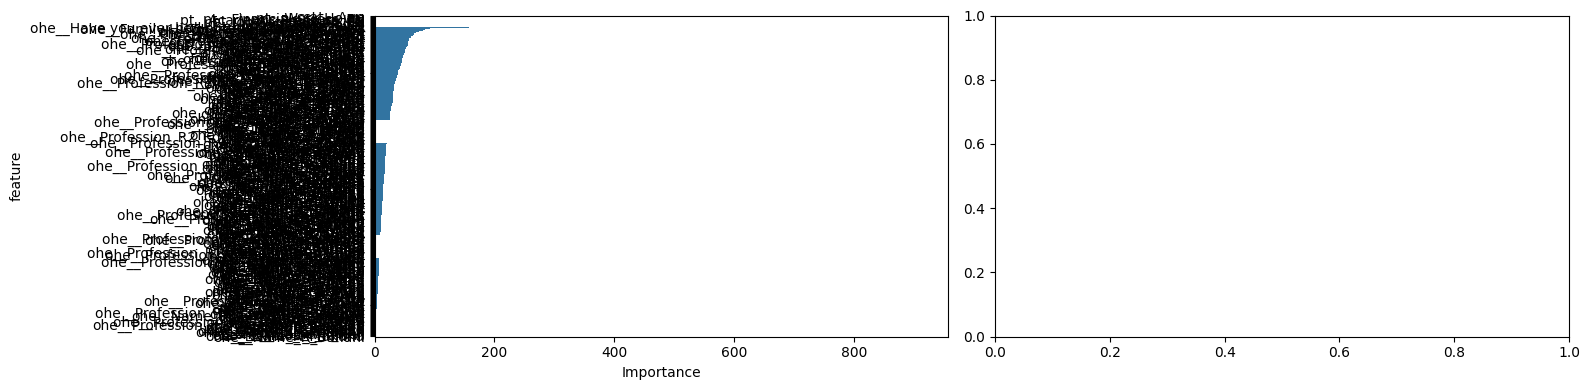

Accuracy, Valid.: 0.94049±0.00159


In [100]:
result = lgb2.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [101]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb2.cv_best_['hparams']).rename('value').to_frame())
print(lgb2.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.04, 'num_leaves': 7, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Academic Pressure_FN, Financial Stress_FN, Work Pressure_FN, Study Satisfaction_FN, Job Satisfaction_FN, Work Hours, Study Hours, CGPA_FN, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Gender]"
X_cat,[Age]
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"


0.9404904051172707


# XGB + LDA

In [102]:
cv_path = os.path.join('result', 'XGB_LDA.cv')
if os.path.exists(cv_path):
    xgb_lda = sgml.CVModel.load('result', 'XGB_LDA')
else:
    xgb_lda = sgml.CVModel('result', 'XGB_LDA', skf, config, xgb_adapter)

In [103]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'max_depth': 3, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 
              'Degree_R', 'City_R', 'Profession_R2', 'Age', 'CGPA_C'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    'lda': {
        'X_mm':  [
            'Academic Pressure_FN', 'Study Hours', 'CGPA_FN', 'Age', 'Study Satisfaction_FN', 
        ],
    },
}
# result = xgb_lda.adhoc(df_train, ss, hparams, device='cuda')
# show_result_lgb(result)
# print(result['train_scores'], result['valid_scores'])

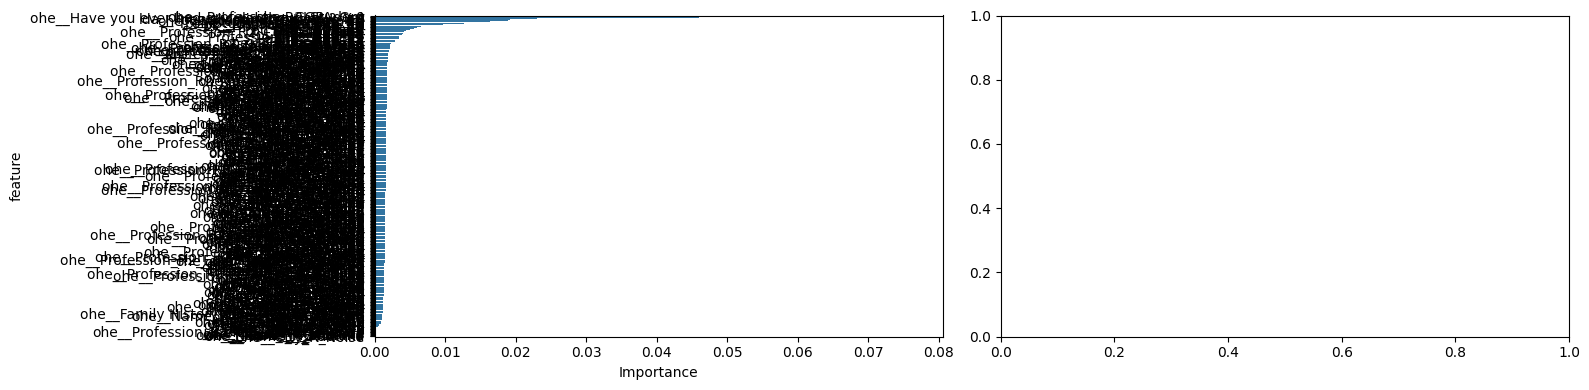

Accuracy, Valid.: 0.94038±0.00180


In [104]:
result = xgb_lda.cv(df_train, hparams, device='cuda')
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [105]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb_lda.cv_best_['hparams']).rename('value').to_frame())
print(xgb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.04, 'max_depth': 3, 'colsample_bytree': 0.25, 'subsample': 0.25}"
X_num,"[Academic Pressure_FN, Financial Stress_FN, Work Pressure_FN, Study Satisfaction_FN, Job Satisfaction_FN, Work Hours, Study Hours, Dietary_level, Sleep_level]"
X_ohe,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age, CGPA_C]"
ohe,"{'min_frequency': 50, 'drop': 'if_binary'}"
lda,"{'X_mm': ['Academic Pressure_FN', 'Study Hours', 'CGPA_FN', 'Age', 'Study Satisfaction_FN']}"


0.9403837953091685


# CB2

In [106]:
cv_path = os.path.join('result', 'CB2.cv')
if os.path.exists(cv_path):
    cb2 = sgml.CVModel.load('result', 'CB2')
else:
    cb2 = sgml.CVModel('result', 'CB2', skf, config, cb_adapter)

In [107]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.05, 'max_depth': 4, 'rsm': 0.5},
    'X_num':  [
        'Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'CGPA_FN', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age', 'Gender'],
    #'validation_fraction': 0.1
}
#result = cb2.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
#print(result['train_scores'], result['valid_scores'])

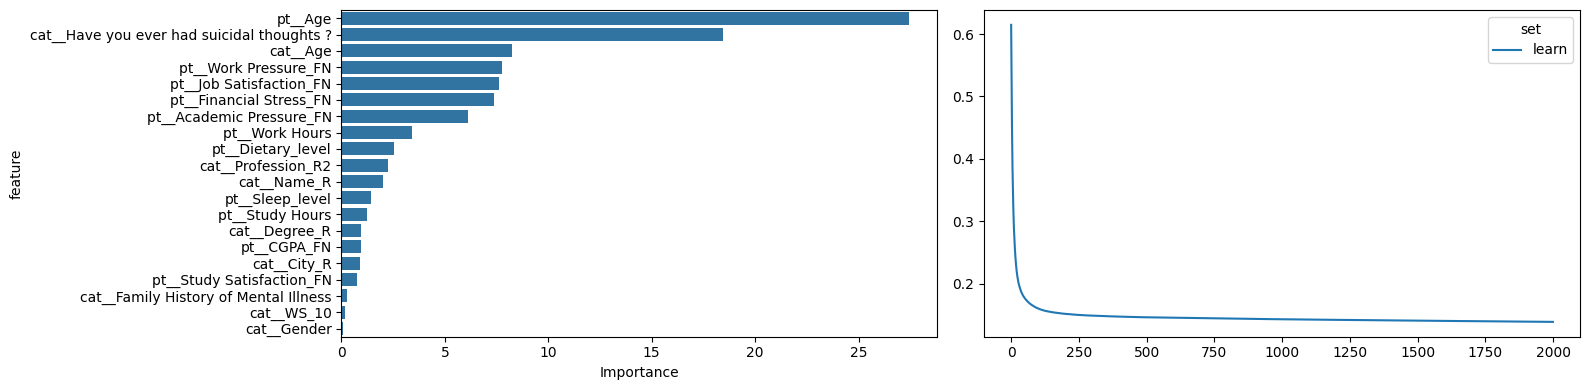

Accuracy, Valid.: 0.94079±0.00211


In [108]:
result = cb2.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [109]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb2.cv_best_['hparams']).rename('value').to_frame())
print(cb2.cv_best_['score'])

,value
model_params,"{'n_estimators': 2000, 'learning_rate': 0.05, 'max_depth': 4, 'rsm': 0.5}"
X_num,"[Age, Academic Pressure_FN, Financial Stress_FN, Work Pressure_FN, Study Satisfaction_FN, Job Satisfaction_FN, Work Hours, Study Hours, CGPA_FN, Dietary_level, Sleep_level]"
X_cat,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age, Gender]"


0.9407889125799574


# CB3

In [110]:
cv_path = os.path.join('result', 'CB3.cv')
if os.path.exists(cv_path):
    cb3 = sgml.CVModel.load('result', 'CB3')
else:
    cb3 = sgml.CVModel('result', 'CB3', skf, config, cb_adapter)

In [111]:
hparams = {
    'model_params': {'n_estimators': 1800, 'learning_rate': 0.03, 'max_depth': 6, 'rsm': 0.5},
    'X_num':  [
        'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 
              'Degree_R', 'City_R', 'Profession_R2', 'Age', 'Gender', 'CGPA_C'],
    #'validation_fraction': 0.1
}
# cb3.adhoc(df_train, ss, hparams)

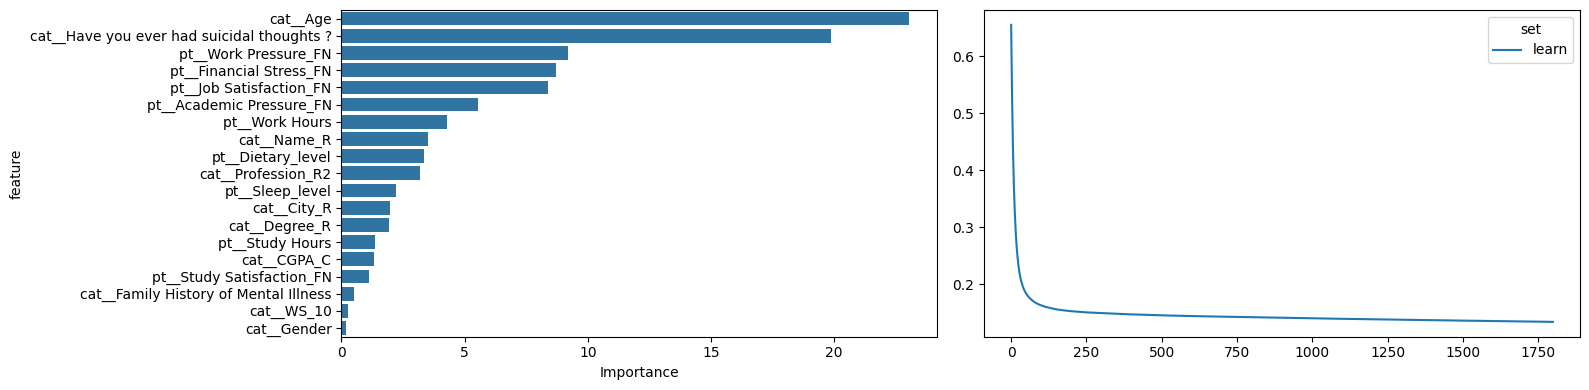

Accuracy, Valid.: 0.94083±0.00179


In [112]:
result = cb3.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [113]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb3.cv_best_['hparams']).rename('value').to_frame())
print(cb3.cv_best_['score'])

,value
model_params,"{'n_estimators': 1800, 'learning_rate': 0.03, 'max_depth': 6, 'rsm': 0.5}"
X_num,"[Academic Pressure_FN, Financial Stress_FN, Work Pressure_FN, Study Satisfaction_FN, Job Satisfaction_FN, Work Hours, Study Hours, Dietary_level, Sleep_level]"
X_cat,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age, Gender, CGPA_C]"


0.9408315565031984


# CB + LDA

In [114]:
cv_path = os.path.join('result', 'CB_LDA.cv')
if os.path.exists(cv_path):
    cb_lda = sgml.CVModel.load('result', 'CB_LDA')
else:
    cb_lda = sgml.CVModel('result', 'CB_LDA', skf, config, cb_adapter)

In [115]:
hparams = {
    'model_params': {'n_estimators': 2500, 'learning_rate': 0.06, 'max_depth': 3},
    'X_num':  [
        'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 'CGPA_FN',
        'Study Hours', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age', 'Gender'],
    'lda': {
        'X_mm':  [
            'Academic Pressure_FN', 'Study Hours', 'CGPA_FN', 'Age', 'Study Satisfaction_FN', 
        ],
        'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first', 'sparse_output': False}
    },
    #'validation_fraction': 0.1
}
#result = cb_lda.adhoc(df_train, ss, hparams)
#show_result_lgb(result)
#print(result['train_scores'], result['valid_scores'])

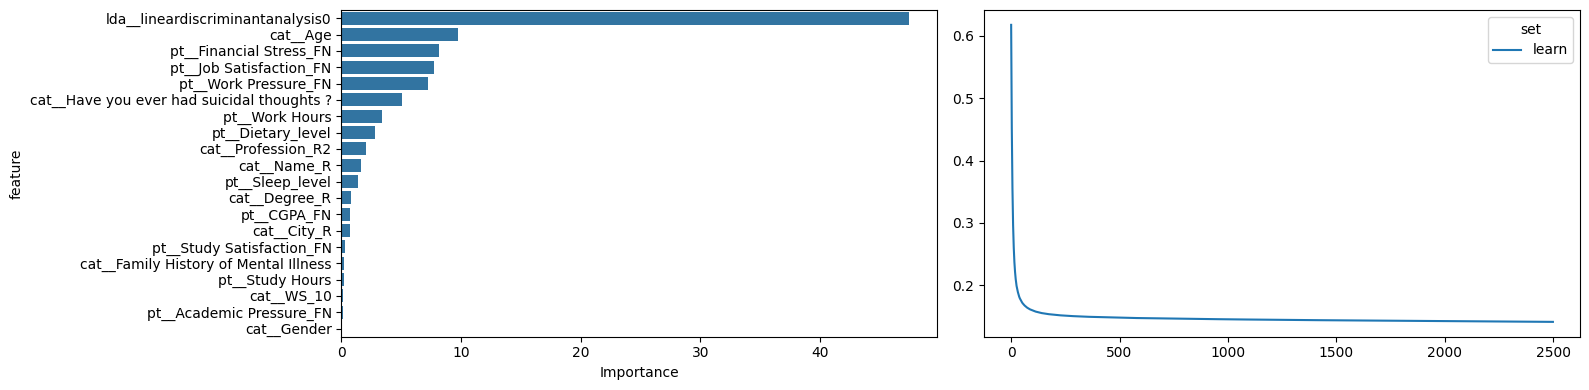

Accuracy, Valid.: 0.94043±0.00185


In [116]:
result = cb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

In [117]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(cb_lda.cv_best_['hparams']).rename('value').to_frame())
print(cb_lda.cv_best_['score'])

,value
model_params,"{'n_estimators': 2500, 'learning_rate': 0.06, 'max_depth': 3}"
X_num,"[Academic Pressure_FN, Financial Stress_FN, Work Pressure_FN, Study Satisfaction_FN, Job Satisfaction_FN, Work Hours, CGPA_FN, Study Hours, Dietary_level, Sleep_level]"
X_cat,"[Name_R, Have you ever had suicidal thoughts ?, WS_10, Family History of Mental Illness, Degree_R, City_R, Profession_R2, Age, Gender]"
lda,"{'X_mm': ['Academic Pressure_FN', 'Study Hours', 'CGPA_FN', 'Age', 'Study Satisfaction_FN'], 'X_ohe': ['Have you ever had suicidal thoughts ?'], 'ohe': {'drop': 'first', 'sparse_output': False}}"


0.9404264392324093


# Stacking

In [190]:
models = [lr, lgb1, lgb2, xgb1, xgb2, cb1, cb2, cb3, nn1, xgb_lda, lgb_lda, cb_lda]
pd.Series([i.cv_best_['score'] for i in models], index=[i.name for i in models]).sort_values(ascending=False).to_frame().T

,CB1,CB3,CB2,XGB1,LGB1,LGB_LDA,LGB2,XGB2,CB_LDA,XGB_LDA,LR,NN1
0,0.940931,0.940832,0.940789,0.94064,0.940611,0.940561,0.94049,0.940455,0.940426,0.940384,0.939865,0.939701


In [191]:
df_stk = sgml.stack_cv(models, df_train[target]).sort_index()
df_stk.corr()

,LR,LGB1,LGB2,XGB1,XGB2,CB1,CB2,CB3,NN1,XGB_LDA,LGB_LDA,CB_LDA,Depression
LR,1.000000,0.995960,0.996212,0.996757,0.997081,0.994000,0.993975,0.992986,0.998718,0.996518,0.995975,0.993849,0.838807
LGB1,0.995960,1.000000,0.999176,0.998261,0.997942,0.996032,0.996032,0.995358,0.995407,0.997325,0.998790,0.995614,0.839789
LGB2,0.996212,0.999176,1.000000,0.998186,0.997967,0.996039,0.996011,0.995345,0.995623,0.997358,0.998895,0.995644,0.839797
XGB1,0.996757,0.998261,0.998186,1.000000,0.999497,0.996793,0.996642,0.995902,0.995999,0.998555,0.997886,0.996283,0.840287
XGB2,0.997081,0.997942,0.997967,0.999497,1.000000,0.996327,0.996201,0.995416,0.996299,0.998645,0.997647,0.995903,0.840125
CB1,0.994000,0.996032,0.996039,0.996793,0.996327,1.000000,0.999024,0.998881,0.993332,0.995388,0.995858,0.998366,0.840372
CB2,0.993975,0.996032,0.996011,0.996642,0.996201,0.999024,1.000000,0.998157,0.993268,0.995341,0.995823,0.998807,0.840019
CB3,0.992986,0.995358,0.995345,0.995902,0.995416,0.998881,0.998157,1.000000,0.992326,0.994554,0.995150,0.997557,0.839879
NN1,0.998718,0.995407,0.995623,0.995999,0.996299,0.993332,0.993268,0.992326,1.000000,0.995882,0.995352,0.993112,0.838575
XGB_LDA,0.996518,0.997325,0.997358,0.998555,0.998645,0.995388,0.995341,0.994554,0.995882,1.000000,0.997208,0.995149,0.839383


In [192]:
(
    accuracy_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB_LDA', 'XGB1', 'LGB1', 'CB3']].mean(axis=1) >= 0.5
    ),
    accuracy_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB_LDA', 'XGB1', 'LGB1', 'CB3', 'LGB2', 'XGB2', 'LR', 'NN1']].mean(axis=1) >= 0.5
    ),
    roc_auc_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB_LDA', 'XGB1', 'LGB1', 'CB3']].mean(axis=1)
    ), 
    roc_auc_score(
        df_stk['Depression'],
        df_stk[['CB1', 'CB2', 'CB_LDA', 'XGB1', 'LGB1', 'CB3', 'LGB2', 'XGB2', 'LR', 'NN1']].mean(axis=1)
    )
)

(0.9409381663113007, 0.9405756929637527, 0.976273164283839, 0.9763695409921231)

In [193]:
from sklearn.linear_model import LogisticRegression
lr_adapter = sgml.SklearnAdapter(LogisticRegression)

cv_path = os.path.join('result', 'stk_lr.cv')
if os.path.exists(cv_path):
    stk = sgml.CVModel.load('result', 'stk_lr')
else:
    skf2 = StratifiedKFold(n_splits=5, random_state=12, shuffle=True)
    stk = sgml.CVModel('result', 'stk_lr', skf2, config, lr_adapter)

In [194]:
hparams={
    'model_params' : {'C': 10},
    'X_num': ['CB1', 'CB2', 'CB_LDA', 'XGB1', 'LGB1', 'CB3', 'LGB2', 'XGB2', 'LR', 'NN1']
}
result = stk.cv(df_stk, hparams, result_proc=sgml.m_learning_result, rerun=1)
print_metrics('Valid. score', result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy, Valid. score: 0.94050±0.00141


In [142]:
pd.concat(
    [pd.Series(i['model'].coef_[0], index=i['variables']) for i in result['model_result']], axis=1
)

,0,1,2,3,4
NN1,0.739666,0.744044,0.742967,0.739097,0.744774
LGB2,0.733720,0.730673,0.729135,0.735277,0.729449
CB3,0.754829,0.755819,0.753193,0.754424,0.754207
CB_LDA,0.737804,0.740439,0.740916,0.739848,0.738637
CB2,0.750512,0.751895,0.753995,0.753247,0.750643
CB1,0.763770,0.766461,0.761410,0.760736,0.762136
XGB2,0.736289,0.739757,0.730540,0.737259,0.736801
LR,0.737908,0.743832,0.744900,0.745169,0.747606
LGB1,0.735062,0.731350,0.735433,0.736083,0.733546
XGB1,0.735426,0.737496,0.729190,0.734033,0.733456


In [142]:
df_confuse = df_train.loc[
    stk.cv_best_['prd'].sort_index().between(0.4, 0.6)
].assign(
    prob = lambda x: stk.cv_best_['prd']
)

In [143]:
len(df_confuse) / len(df_train), roc_auc_score(df_confuse[target], df_confuse['prob'])

(0.01669509594882729, 0.5287928682179563)

In [144]:
df_confuse[target].value_counts()

Depression
1    1241
0    1108
Name: count, dtype: int64

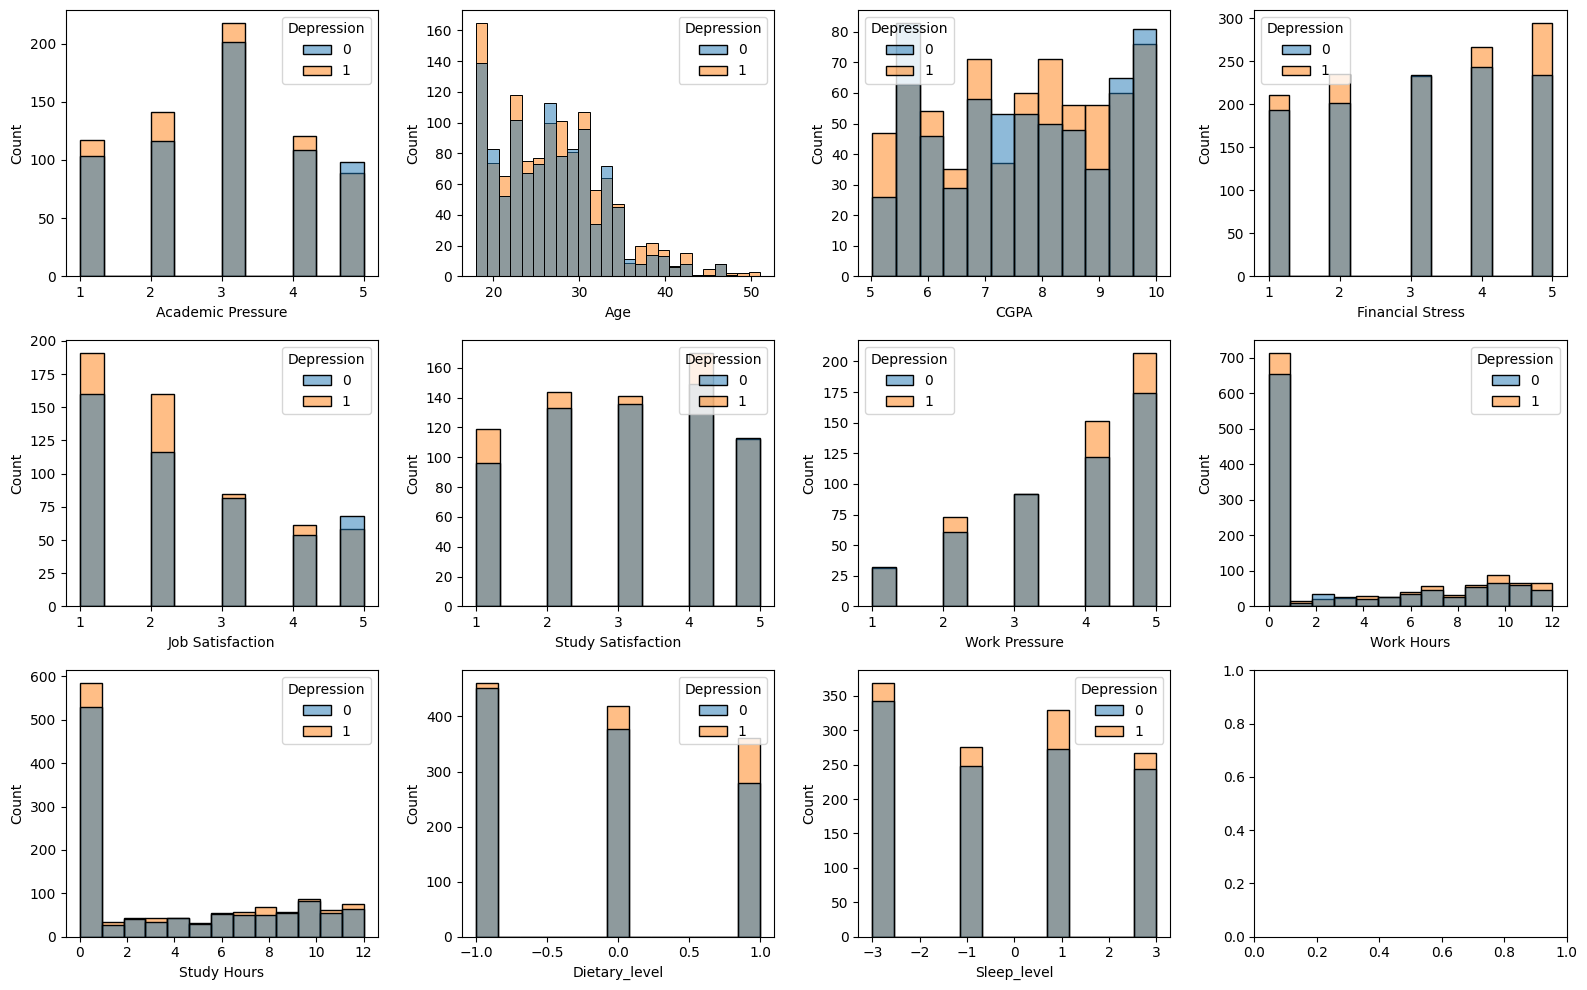

In [145]:
X_cont = ['Academic Pressure', 'Age', 'CGPA',  'Financial Stress', 'Job Satisfaction', 'Study Satisfaction',  'Work Pressure', 
          'Work Hours', 'Study Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_confuse, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [146]:
pd.concat([
    df_confuse['Profession_R2'].value_counts().rename('confuse'),
    df_train['Profession_R2'].value_counts().rename('train'),
    df_confuse.groupby('Profession_R2', observed=True)[target].mean().rename('confuse_target'), 
    df_train.groupby('Profession_R2', observed=True)[target].mean().rename('train_target'), 
    df_confuse.groupby('Profession_R2', observed=True)[target].sum().rename('confuse_target_cnt'),
    df_train.groupby('Profession_R2', observed=True)[target].sum().rename('train_target_cnt'),
], axis=1).assign(
    ratio = lambda x: x['confuse'] / x['train']
).sort_values('confuse', ascending=False).iloc[:10]

,confuse,train,confuse_target,train_target,confuse_target_cnt,train_target_cnt,ratio
Profession_R2,,,,,,,
Student,1313,27901,0.522468,0.585535,686.0,16337,0.047059
Unknown,303,8768,0.531353,0.374886,161.0,3287,0.034557
Teacher,181,24900,0.535912,0.055462,97.0,1381,0.007269
Architect,45,4362,0.533333,0.097662,24.0,426,0.010316
HR Manager,43,4022,0.465116,0.106912,20.0,430,0.010691
Educational Consultant,27,2851,0.481481,0.074360,13.0,212,0.009470
Consultant,27,4229,0.555556,0.047056,15.0,199,0.006384
Judge,25,1712,0.520000,0.108645,13.0,186,0.014603
Content Writer,24,7811,0.750000,0.018308,18.0,143,0.003073


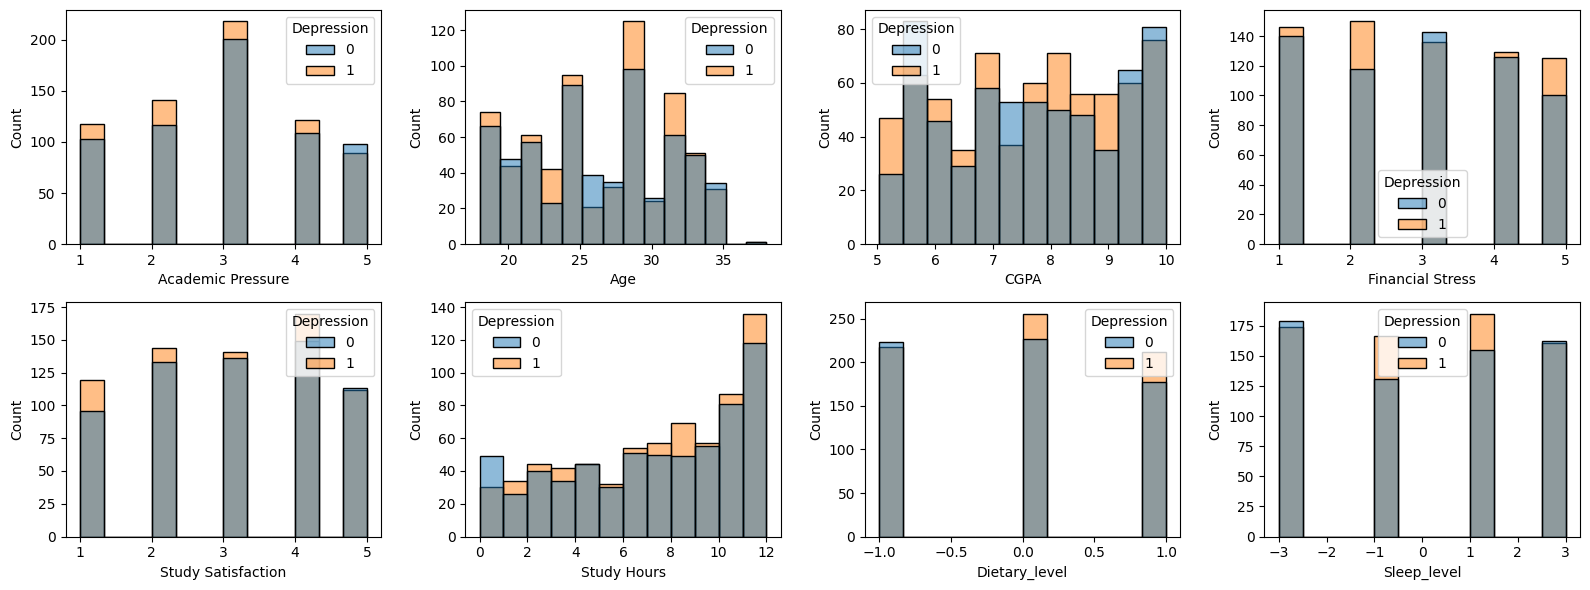

In [147]:
X_cont = ['Academic Pressure', 'Age', 'CGPA',  'Financial Stress', 'Study Satisfaction', 
          'Study Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_confuse_student = df_confuse.loc[df_confuse['Profession_R2'] == 'Student']
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_confuse_student, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [148]:
df_confuse_student.pivot_table(index='Gender',  columns=target, aggfunc='size', observed=True)

Depression,0,1
Gender,,
Female,289,304
Male,338,382


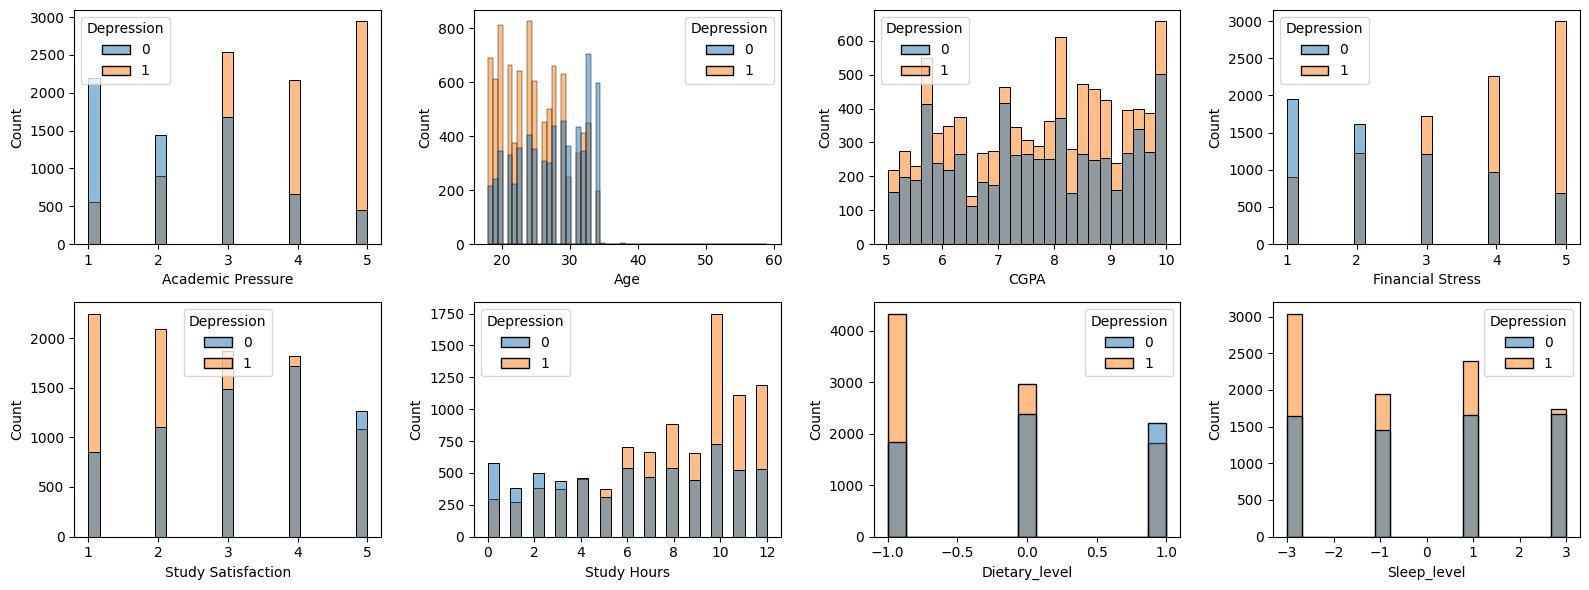

In [149]:
X_cont = ['Academic Pressure', 'Age', 'CGPA',  'Financial Stress', 'Study Satisfaction', 
          'Study Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_student_male = df_train.loc[(df_train['Profession_R2'] == 'Student') & (df_train['Gender'] == 'Male')]
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train_student_male, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

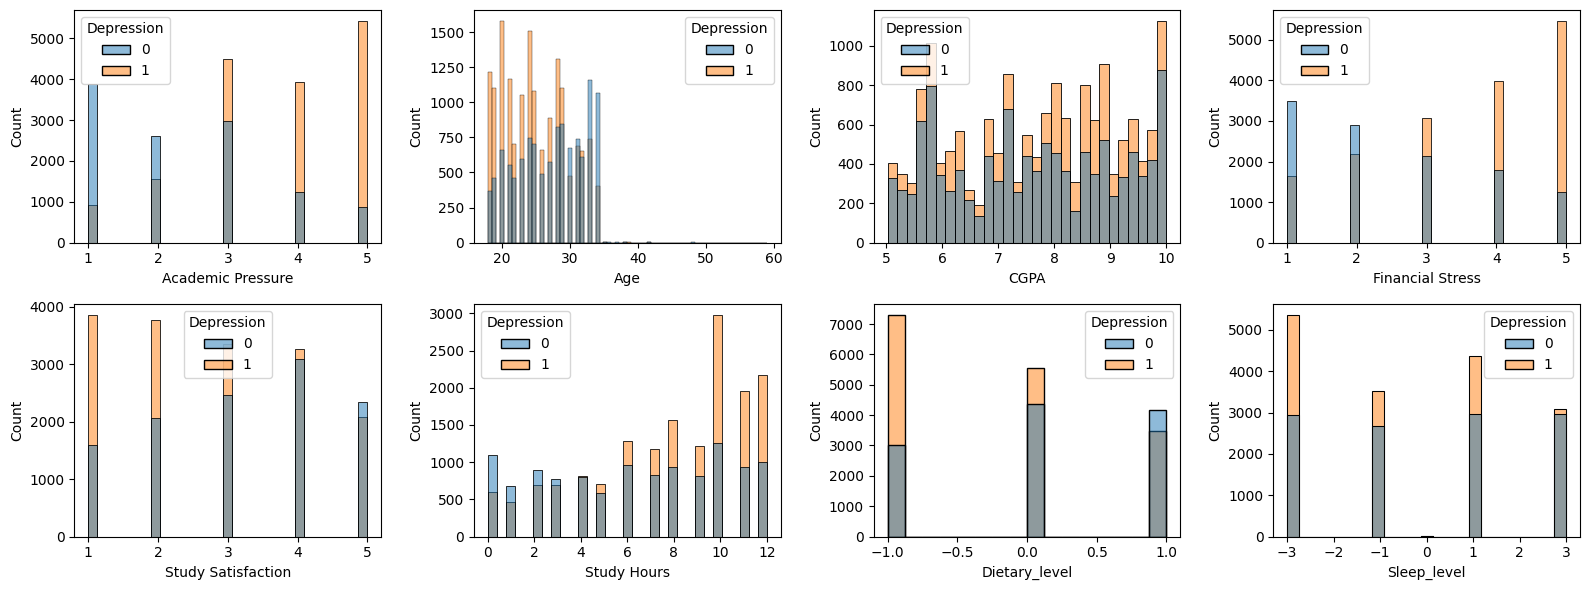

In [150]:
X_cont = ['Academic Pressure', 'Age', 'CGPA',  'Financial Stress', 'Study Satisfaction', 
          'Study Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_student = df_train.loc[df_train['Profession_R2'] == 'Student']
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train_student, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [151]:
df_train_student['Age'].value_counts()

Age
24    2258
20    2236
28    2133
29    1951
33    1893
25    1784
21    1725
23    1645
18    1587
19    1561
34    1469
27    1462
31    1427
32    1262
22    1160
26    1155
30    1145
35      10
38       7
36       7
42       4
48       3
39       3
43       2
46       2
37       2
51       1
44       1
49       1
59       1
54       1
58       1
56       1
41       1
Name: count, dtype: int64

In [152]:
from scipy.stats import f_oneway
df_train_student[['Degree_R', 'City_R']].apply(
    lambda x: f_oneway(*df_train_student.groupby(x, observed=True)['CGPA'].agg(lambda x: list(x.dropna()))),
    axis=0
)

,Degree_R,City_R
0,6.558187e+00,9.768200e+00
1,1.031677e-20,1.157018e-44


In [153]:
df_train_student.pivot_table(index='Age', columns='Degree_R', values=target, aggfunc='mean', observed=True).iloc[:20]

Degree_R,Noise,Class 12,B.Ed,B.Arch,B.Com,B.Pharm,BCA,M.Ed,MCA,BBA,...,LLB,BHM,MBA,ME,MD,BE,PhD,M.Com,MBBS,MA
Age,,,,,,,,,,,,,,,,,,,,,
18,0.666667,0.766646,1.000000,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,1.000000
19,1.000000,0.705161,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN
20,0.642857,0.707840,0.000000,NaN,0.500000,NaN,1.000000,1.000000,0.000000,NaN,...,NaN,0.400000,1.000000,NaN,NaN,1.000000,NaN,1.000000,0.500000,0.500000
21,0.613208,0.737374,0.696629,0.700000,0.704545,0.588235,0.680272,0.761905,0.659389,0.763158,...,0.800000,0.666667,0.647059,1.000000,0.714286,0.727273,0.400000,0.633333,0.571429,0.676923
22,0.597015,0.538462,0.652174,0.534884,0.577465,0.625000,0.696774,0.857143,0.584270,0.606742,...,0.333333,0.580247,0.578947,0.333333,1.000000,0.478261,0.500000,0.582090,0.777778,0.350000
23,0.640751,0.875000,0.629213,0.642857,0.645833,0.517241,0.584158,0.500000,0.625000,0.611940,...,0.777778,0.621951,0.690476,0.000000,0.600000,0.604651,0.625000,0.566667,0.705882,0.729730
24,0.647975,0.702381,0.693122,0.658307,0.720930,0.610294,0.763441,0.566667,0.618182,0.696970,...,0.500000,0.717647,0.642857,0.500000,0.700000,0.605263,0.300000,0.666667,0.676923,0.464286
25,0.583333,0.586957,0.663594,0.563953,0.645833,0.575000,0.600000,0.597015,0.620000,0.511111,...,0.500000,0.575472,0.677419,0.500000,0.550000,0.604651,0.647887,0.580645,0.617647,0.621622
26,0.523364,0.486486,0.580000,0.509091,0.616438,0.631579,0.580000,0.640000,0.648148,0.637500,...,0.733333,0.612903,0.363636,0.600000,0.500000,0.571429,0.730769,0.555556,0.666667,0.344828


<Axes: xlabel='Academic Pressure', ylabel='Study Hours'>

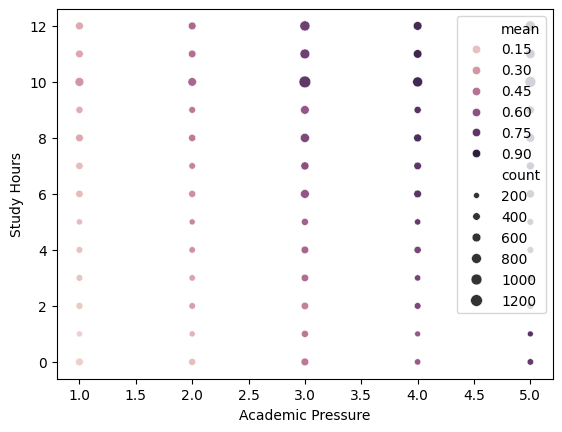

In [154]:
df_train_student.groupby(['Academic Pressure','Study Hours'], as_index=False)[target].agg(['mean', 'count']).pipe(
    lambda x: sns.scatterplot(x, x='Academic Pressure', y = 'Study Hours', hue='mean', size='count')
)

<Axes: xlabel='Study Satisfaction', ylabel='Study Hours'>

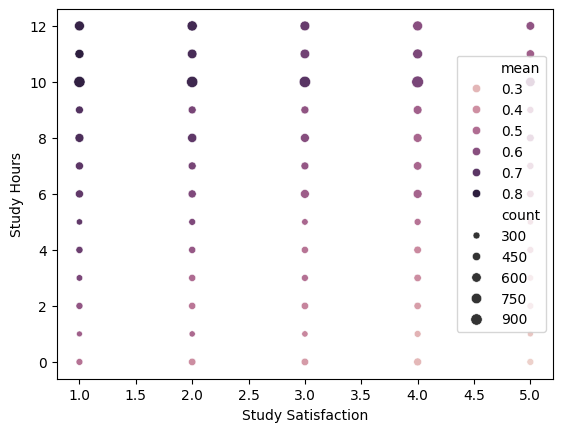

In [155]:
df_train_student.groupby(['Study Satisfaction','Study Hours'], as_index=False)[target].agg(['mean', 'count']).pipe(
    lambda x: sns.scatterplot(x, x='Study Satisfaction', y = 'Study Hours', hue='mean', size='count')
)

In [156]:
df_train_student[X_cont].corr().loc['Academic Pressure']

Academic Pressure     1.000000
Age                  -0.075956
CGPA                 -0.025195
Financial Stress      0.152105
Study Satisfaction   -0.112228
Study Hours           0.095650
Dietary_level        -0.089283
Sleep_level          -0.043402
Name: Academic Pressure, dtype: float64

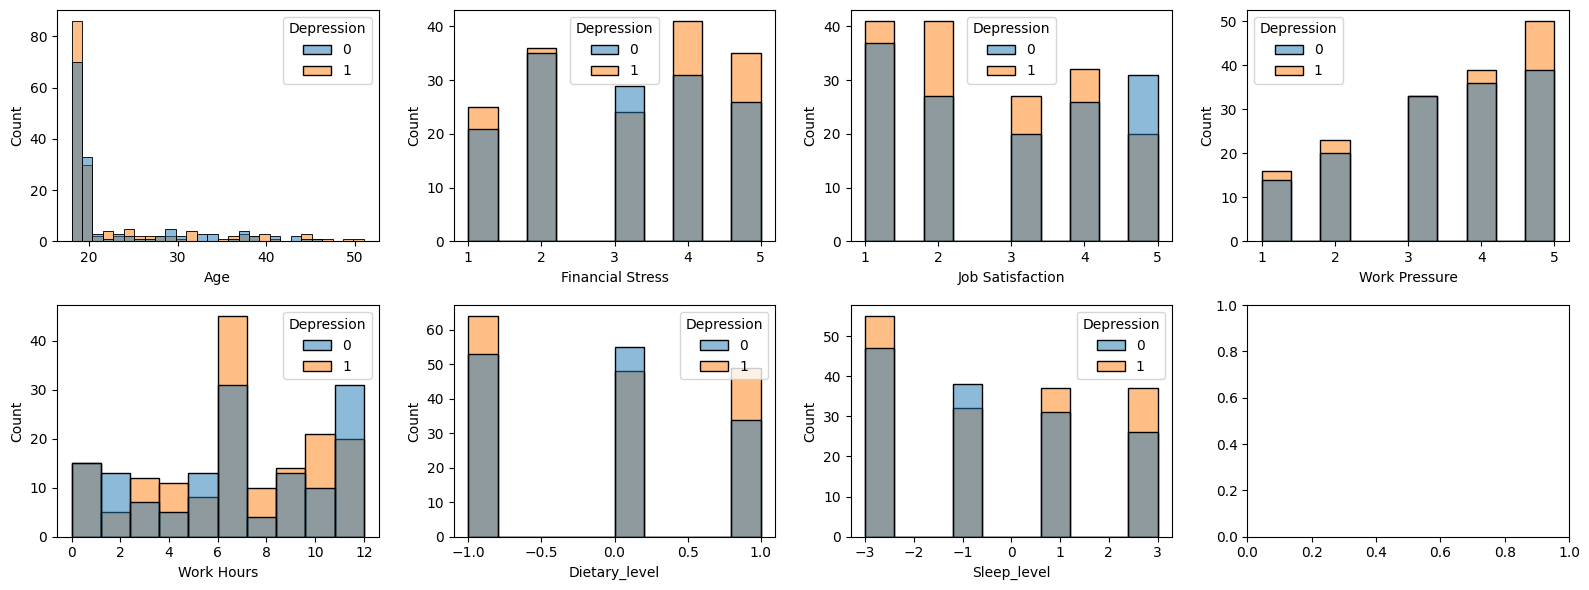

In [157]:
X_cont = ['Age', 'Financial Stress', 'Job Satisfaction', 'Work Pressure', 
          'Work Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_confuse_unknown = df_confuse.loc[df_confuse['Profession_R2'].isin(['Unknown'])]
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_confuse_unknown, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

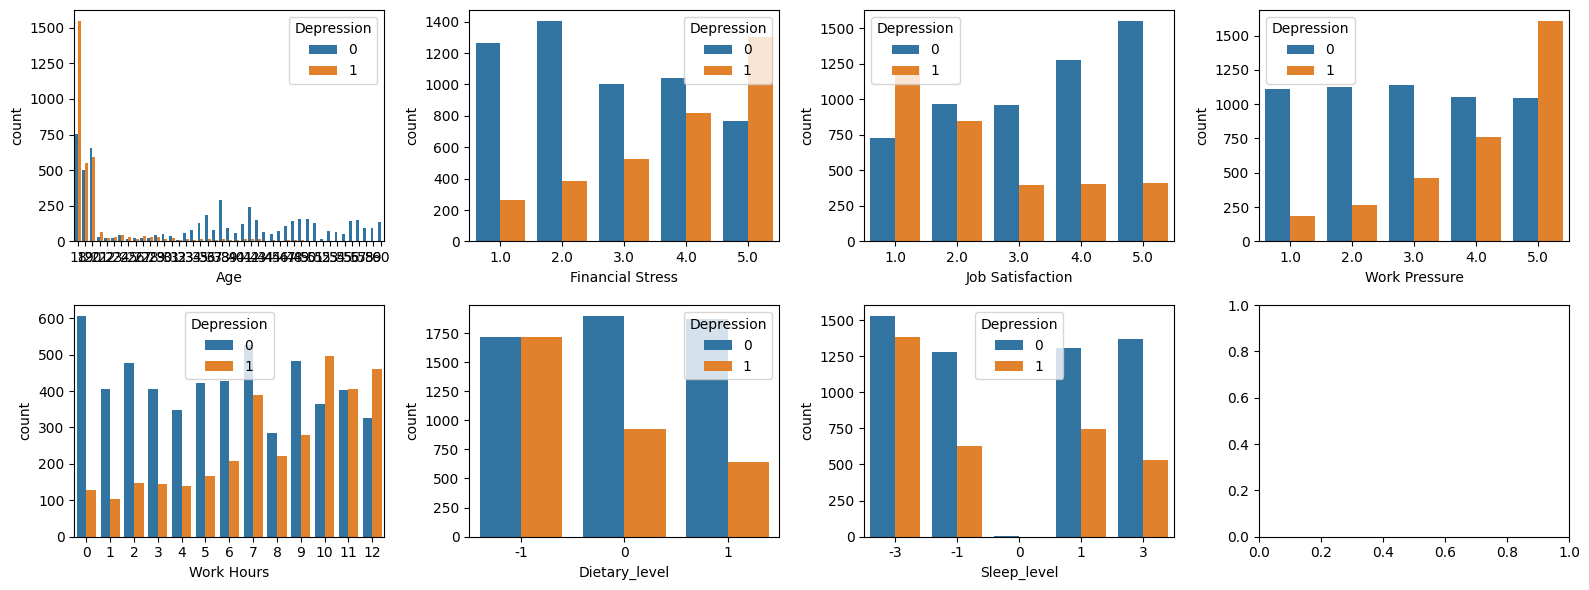

In [158]:
X_cont = ['Age', 'Financial Stress', 'Job Satisfaction', 'Work Pressure', 
          'Work Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_unknown = df_train.loc[df_train['Profession_R2'].isin(['Unknown'])]
for i, ax in zip(X_cont, axes.flatten()):
    sns.countplot(df_train_unknown, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [159]:
df_train_unknown.pivot_table(index='Age', columns=target, aggfunc='size').iloc[:5]

Depression,0,1
Age,,
18,757.0,1547.0
19,499.0,553.0
20,656.0,594.0
21,34.0,66.0
22,23.0,21.0


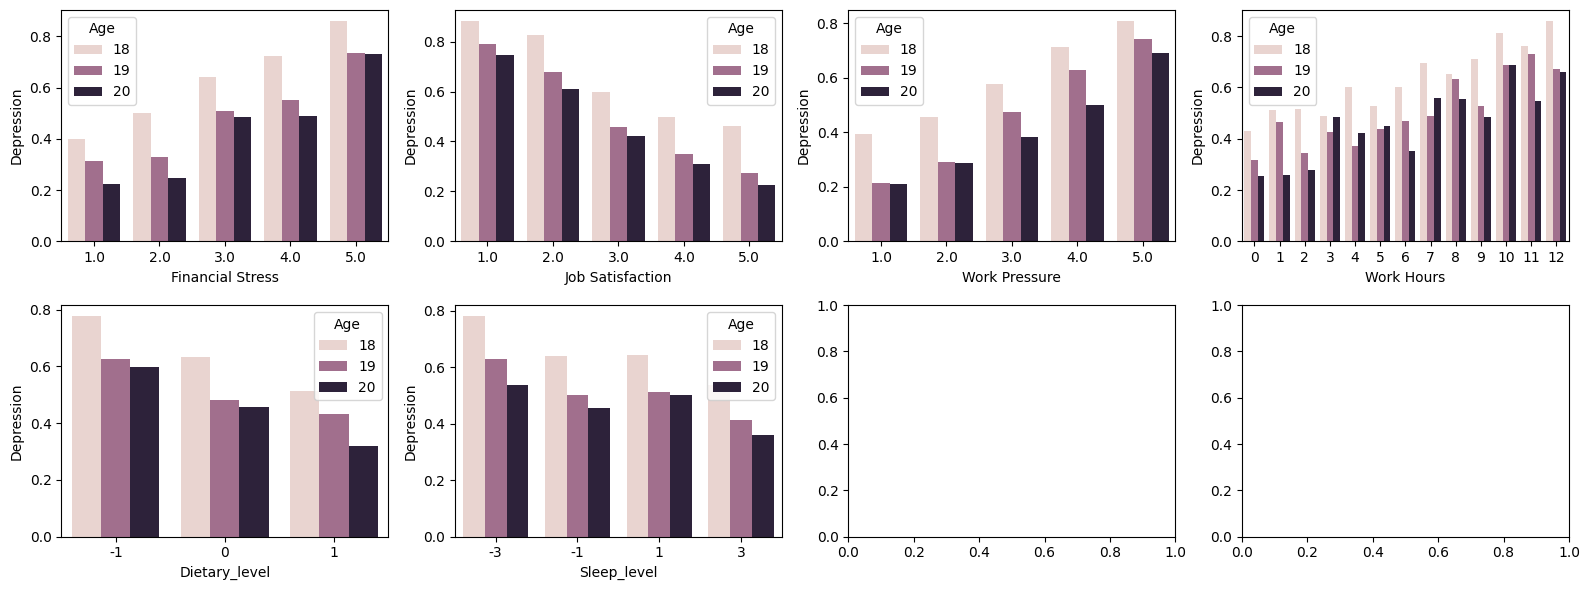

In [160]:
X_cont = ['Financial Stress', 'Job Satisfaction', 'Work Pressure', 
          'Work Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_unknown_20 = df_train.loc[(df_train['Profession_R2'] == 'Unknown') & (df_train['Age'] <= 20)]
for i, ax in zip(X_cont, axes.flatten()):
    sns.barplot(df_train_unknown_20.groupby(['Age', i], as_index=False)[target].mean(), x=i, y=target, hue='Age', ax=ax)
plt.tight_layout()
plt.show()

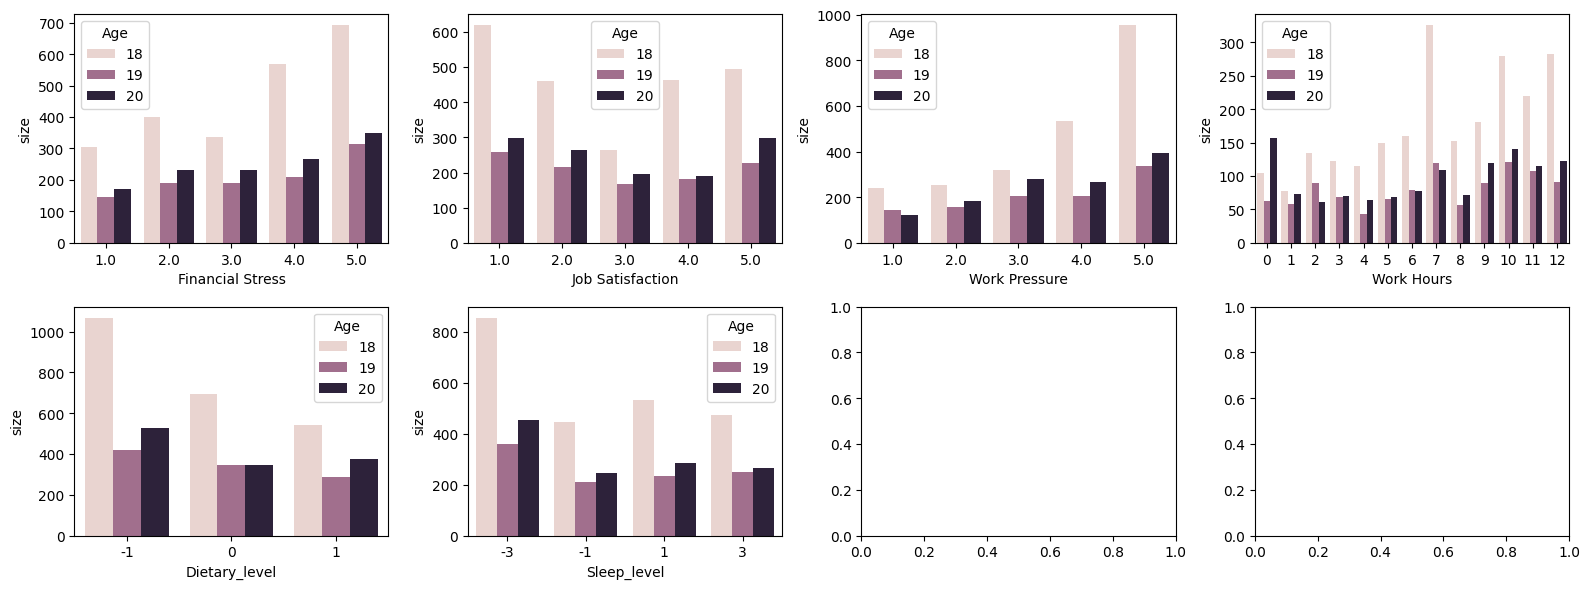

In [161]:
X_cont = ['Financial Stress', 'Job Satisfaction', 'Work Pressure', 
          'Work Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_unknown_20 = df_train.loc[(df_train['Profession_R2'] == 'Unknown') & (df_train['Age'] <= 20)]
for i, ax in zip(X_cont, axes.flatten()):
    sns.barplot(df_train_unknown_20.groupby(['Age', i], as_index=False).size(), x=i, y='size', hue='Age', ax=ax)
plt.tight_layout()
plt.show()

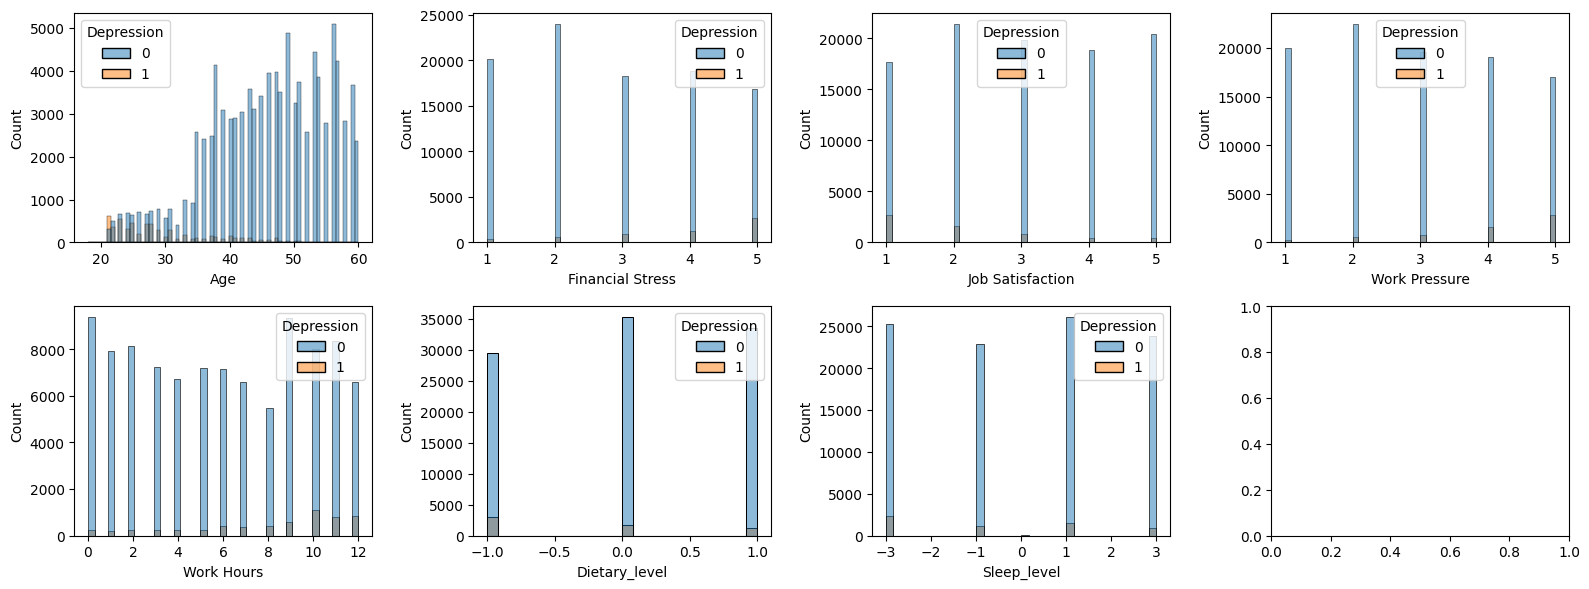

In [162]:
X_cont = ['Age', 'Financial Stress', 'Job Satisfaction', 'Work Pressure', 
          'Work Hours', 'Dietary_level', 'Sleep_level']
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
df_train_not_student = df_train.loc[~df_train['Profession_R2'].isin(['Student', 'Unknown'])]
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train_not_student, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [163]:
hparams = {
    'model_params': {'n_estimators': 100, 'num_leaves': 3},
    'X_num':  [
       'Financial Stress_FN'
    ],
    'X_ohe': ['Family History of Mental Illness', 'Gender'],
    'ohe': {'min_frequency': 10, 'drop': 'if_binary', 'handle_unknown': 'ignore'},
}
result = lgb1.adhoc(df_confuse, StratifiedKFold(5), hparams)

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

In [164]:
(
    result['model_result'][0]['feature_importance'][-20:], 
    result['train_scores'], result['valid_scores'], 
    roc_auc_score(df_confuse[target].sort_index(), result['valid_prd'].sort_index())
)

(ohe__Family History of Mental Illness_Yes    48
 ohe__Gender_Male                             57
 pt__Financial Stress_FN                      95
 dtype: int32,
 [0.5428419372006387,
  0.525279403938265,
  0.5306013837147419,
  0.535391165513571,
  0.5393617021276595],
 [0.4787234042553192, 0.5063829787234042, 0.5, 0.5, 0.5010660980810234],
 0.4840657790241363)

In [165]:
df_train.pivot_table(index=['Family History of Mental Illness', 'Gender'], columns=target, aggfunc='size', observed=False).assign(
    ratio = lambda x: x[1] / x.sum(axis=1)
)

Depression                                   0     1     ratio
Family History of Mental Illness Gender                       
No                               Female  25939  5320  0.170191
                                 Male    32409  7090  0.179498
Yes                              Female  26026  5951  0.186103
                                 Male    30759  7206  0.189806

In [166]:
df_confuse.pivot_table(index=['Family History of Mental Illness', 'Gender'], columns=target, aggfunc='size', observed=False).assign(
    ratio = lambda x: x[1] / x.sum(axis=1)
)

Depression                                 0    1     ratio
Family History of Mental Illness Gender                    
No                               Female  263  276  0.512059
                                 Male    318  371  0.538462
Yes                              Female  228  288  0.558140
                                 Male    299  306  0.505785

In [167]:
models = [cb1, cb2, cb_lda, xgb1, lgb1, cb3]
for i in models:
    i.train(df_train)

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2500 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/1800 [00:00<?, ?it/s]

In [168]:
df_test = pl.read_parquet(files['test_parquet'])
df_test = df_test.to_pandas().set_index('id')

In [169]:
df_test, nq = sc.cache_result(
    'test_set',
    lambda : dproc.apply_pd_procs(df_test, pd.Series(df_var.loc[df_var['processor'].notna(), 'processor'].unique())), 1
)
df_test

,Name,Gender,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,...,WS_10,Prof_Degree,Age_20_Unknown,Academic Pressure_FN,CGPA_FN,Study Satisfaction_FN,Work Pressure_FN,Job Satisfaction_FN,Financial Stress_FN,CGPA_C
id,,,,,,,,,,,,,,,,,,,,,
140700,Shivam,Male,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,...,False,Judge_LLB,False,0,0.00,0,2,5,3,0
140701,Sanya,Female,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,...,False,Educational Consultant_B.Ed,False,0,0.00,0,2,4,4,0
140702,Yash,Male,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,...,False,Teacher_B.Arch,False,0,0.00,0,4,1,4,0
140703,Nalini,Female,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,...,True,Student_Noise,False,5,6.84,1,0,0,4,68
140704,Shaurya,Male,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,...,False,Teacher_BCA,False,0,0.00,0,5,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234495,Zoya,Female,Jaipur,Working Professional,Pilot,NaN,3.0,NaN,NaN,5.0,...,False,Pilot_Noise,False,0,0.00,0,3,5,2,0
234496,Shlok,Male,Ahmedabad,Working Professional,Pilot,NaN,5.0,NaN,NaN,1.0,...,False,Pilot_BE,False,0,0.00,0,5,1,3,0
234497,Rishi,Male,Visakhapatnam,Student,NaN,1.0,NaN,7.51,4.0,NaN,...,False,Student_B.Tech,False,1,7.51,4,0,0,1,75


# VT1

In [170]:
df_vt = pd.concat([
    i.get_predictor()(df_test).rename(i.name)
    for i in models
], axis=1)
display(df_vt.head())
(df_vt.mean(axis=1) > 0.5).astype('int').rename('Depression').to_frame().to_csv('data/1.csv')
# !kaggle competitions submit -c playground-series-s4e11 -f data/1.csv -m "1"

,CB1,CB2,CB_LDA,XGB1,LGB1,CB3
id,,,,,,
140700,0.000266,0.000288,0.000925,0.000601,0.000608,0.001473
140701,0.000133,0.000134,0.000306,0.000168,0.000170,0.000772
140702,0.023614,0.026304,0.026448,0.019523,0.024175,0.068412
140703,0.981731,0.981458,0.979701,0.981752,0.977250,0.980033
140704,0.018944,0.021027,0.020638,0.022529,0.021563,0.014998


100%|█████████████████████████████████████████| 824k/824k [00:01<00:00, 438kB/s]
Successfully submitted to Exploring Mental Health Data

In [ ]:
stk.train(df_stk)

In [ ]:
stk.get_predictor()(df_stk_test)